Modification of NuScenes Qualitative.ipynb file to inspect and plot Trajectron predictions.

In [1]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

In [2]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [3]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

Scene is organized as a temporal graph

https://en.wikipedia.org/wiki/Temporal_network

In [11]:
print("Content of eval_env:", *eval_env.__dict__.keys())

scene = eval_env.scenes[25]

# get vehicle nodes at various timesteps
timestep = np.array([10, 20, 30])
scene.present_nodes(timestep, type=eval_env.NodeType.VEHICLE)

Content of eval_env: scenes node_type_list attention_radius NodeType robot_type standardization standardize_param_memo _scenes_resample_prop


{10: [VEHICLE/ego,
  VEHICLE/c1932b698eb445fcba4ceb9db6a38556,
  VEHICLE/e8b0b33be1a647dc8a329d21188fb849,
  VEHICLE/2b4cd40aad5547629d6f7dab2b6a247b,
  VEHICLE/be6935a41c3e47bda91e38baf47543c7,
  VEHICLE/0b99dd853db1493098d9f28e3306c809,
  VEHICLE/9e8ed3e41ce344f79d6ccc41a689446a],
 20: [VEHICLE/ego,
  VEHICLE/be6935a41c3e47bda91e38baf47543c7,
  VEHICLE/0b99dd853db1493098d9f28e3306c809,
  VEHICLE/2557cc3e09a74114ae7ac400b25ba018,
  VEHICLE/1245aa3bc4164788833377ce915252d2,
  VEHICLE/669e4df699184564a2b0329460ed0c2b],
 30: [VEHICLE/ego,
  VEHICLE/be6935a41c3e47bda91e38baf47543c7,
  VEHICLE/0b99dd853db1493098d9f28e3306c809,
  VEHICLE/2557cc3e09a74114ae7ac400b25ba018,
  VEHICLE/1245aa3bc4164788833377ce915252d2,
  VEHICLE/669e4df699184564a2b0329460ed0c2b,
  VEHICLE/fb8776cf5ea541158073d4a13da48312]}

In [14]:
# get initial ego vehicle coordinates at a scene (needs to modify Scene class and preprocessing script).
scene = eval_env.scenes[3]
scene.ego_initx, scene.ego_inity

(1032.45108824576, 847.8152261909415)

How to run the model:

Use `Trajectron.predict()` to get the forecasts.  

```
Trajectron.predict(scene, timesteps, ph, num_samples=1, min_future_timesteps=0, min_history_timesteps=1, z_mode=False, gmm_mode=False, full_dist=True, all_z_sep=False)
```

`scene` : a Scene object containing a scene we want to predict.  
`timesteps` : ndarray of integers used by `scene` passed as the argument to call `Scene.present_nodes()` getting the nodes for the specified timesteps.  
`ph` : prediction horizon, or the number of future timesteps to predict used by `MultimodalGenerativeCVAE.p_y_xz()` for relevant nodes.  
`num_samples` : number of times to sample predictions. Essentially samples $p(z | x)$ and then $p(y | x,z)$ `num_samples` times.  
`min_future_timesteps`  
`min_history_timesteps`  
`z_mode`  
`gmm_mode`  
`full_dist`: passed to `DiscreteLatent.sample_p()` so that we generate `num_samples` number of discrete latent variables $z$.  
`all_z_sep`  

Comments:

`full_dist` does not give multimodal distributions.

Forecasts trajectory is sampled from a gaussian mixture model using the GMM2D class. It seems like GMM2D can additionally be used to sample corresponding linear and angular velocities for the forecasts.

Classes involved:

- ModelRegistrar : contains the Trajectron model's computation graph. Contains train(), eval() and predict() functions.
- DiscreteLatent : contains the distribution (i.e. torch OneHotCategorical) of latent variable used to encode high level behavior of a node (vehicle, pedestrian)
- MultimodalGenerativeCVAE : builds the computation graph corresponding to a prediction node type (vehicle, pedestrian). It contains a DiscreteLatent as `latent` attribute.
- Trajectron : the model API. Contains a ModelRegistrar. Contains a MultimodalGenerativeCVAE for each prediction type (vehicle, pedestrian) in the `dict` `node_models_dict` attribute.

In [6]:
# Load model
ph = 6
log_dir = './models'
model_dir = os.path.join(log_dir, 'int_ee_me')
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=12)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



In [7]:
# get a scene from evaluation scenes
scene = eval_scenes[25]

# Define ROI in nuScenes Map
x_min = 773.0
x_max = 1100.0
y_min = 1231.0
y_max = 1510.0

# Define layers in nuScenes Map
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

AGENT_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

scene.name

'105'

What does a prediction from Trajectron look like?

In [8]:
ph = 6
num_samples=24
t = 2
timesteps = np.array([t])
with torch.no_grad():
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=True,
                all_z_sep=False)

In [9]:
print("Prediction for timestep(s):", *predictions.keys())
prediction = predictions[t]
# prediction is a dict of Node, ndarray
node, arr = list(prediction.items())[0]
print("Prediction node and predictions")
print(f"{arr.shape[0]} ???, {arr.shape[1]} samples, "
      f"{arr.shape[2]} future timesteps (ph), {arr.shape[3]} of xy-coordinates")
print("Node and prediction", node, arr.shape)

Prediction for timestep(s): 2
Prediction node and predictions
1 ???, 24 samples, 6 future timesteps (ph), 2 of xy-coordinates
Node and prediction VEHICLE/ego (1, 24, 6, 2)


In [ ]:
node

In [9]:
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
list(v_nodes)

[VEHICLE/ego,
 VEHICLE/c1932b698eb445fcba4ceb9db6a38556,
 VEHICLE/e8b0b33be1a647dc8a329d21188fb849,
 VEHICLE/2b4cd40aad5547629d6f7dab2b6a247b,
 VEHICLE/be6935a41c3e47bda91e38baf47543c7,
 VEHICLE/0b99dd853db1493098d9f28e3306c809]

In [10]:
prediction_dict, histories_dict, futures_dict = \
        prediction_output_to_trajectories(
            predictions, dt=scene.dt, max_h=10, ph=6, map=None)

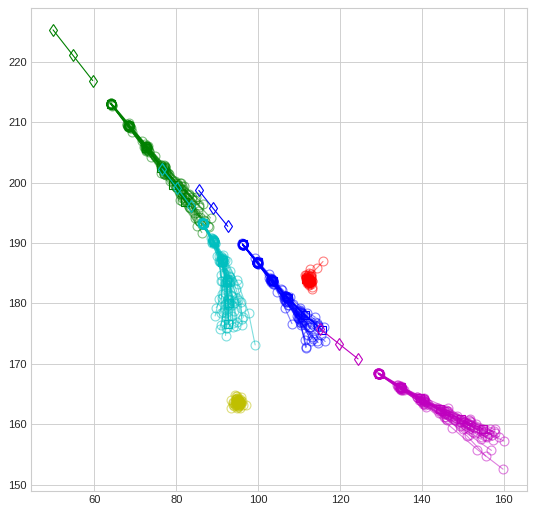

In [11]:
plt.figure(figsize=(8, 8), dpi=80)
for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    plt.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx],
                linewidth=1, markersize=8, markerfacecolor='none')
    plt.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        plt.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx], alpha=0.5,
                linewidth=1, markersize=8, markerfacecolor='none')

plt.show()

In [12]:
# predicted trajectories
print(prediction_dict[2][node].shape)
prediction_dict[2][node]

(1, 24, 6, 2)


array([[[[ 95.117165, 163.64645 ],
         [ 95.08177 , 163.64304 ],
         [ 94.999954, 163.65564 ],
         [ 94.850586, 163.69205 ],
         [ 94.76105 , 163.7038  ],
         [ 94.76879 , 163.70183 ]],

        [[ 95.13085 , 163.647   ],
         [ 95.11696 , 163.64694 ],
         [ 95.22446 , 163.53305 ],
         [ 95.27359 , 163.345   ],
         [ 95.266335, 163.20319 ],
         [ 95.24115 , 163.10141 ]],

        [[ 95.14203 , 163.6702  ],
         [ 95.10634 , 163.56973 ],
         [ 95.02923 , 163.33536 ],
         [ 95.00833 , 163.07234 ],
         [ 95.00343 , 162.90436 ],
         [ 94.97406 , 162.74196 ]],

        [[ 95.17299 , 163.65062 ],
         [ 95.22752 , 163.65407 ],
         [ 95.3219  , 163.65154 ],
         [ 95.44489 , 163.64952 ],
         [ 95.444305, 163.57886 ],
         [ 95.40926 , 163.5667  ]],

        [[ 95.13996 , 163.647   ],
         [ 95.15098 , 163.64726 ],
         [ 95.344696, 163.66243 ],
         [ 95.55869 , 163.65247 ],
         [ 9

In [13]:
# histories: past trajectories used for inference of ego vehicle
histories_dict[2][node]

array([[ 95.124, 163.647],
       [ 95.124, 163.647],
       [ 95.124, 163.647]])

In [14]:
# futures: ground truth trajectories of ego vehicle
futures_dict[2][node]

array([[ 95.124, 163.647],
       [ 95.124, 163.647],
       [ 95.124, 163.647],
       [ 95.124, 163.647],
       [ 95.124, 163.647],
       [ 95.124, 163.647]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


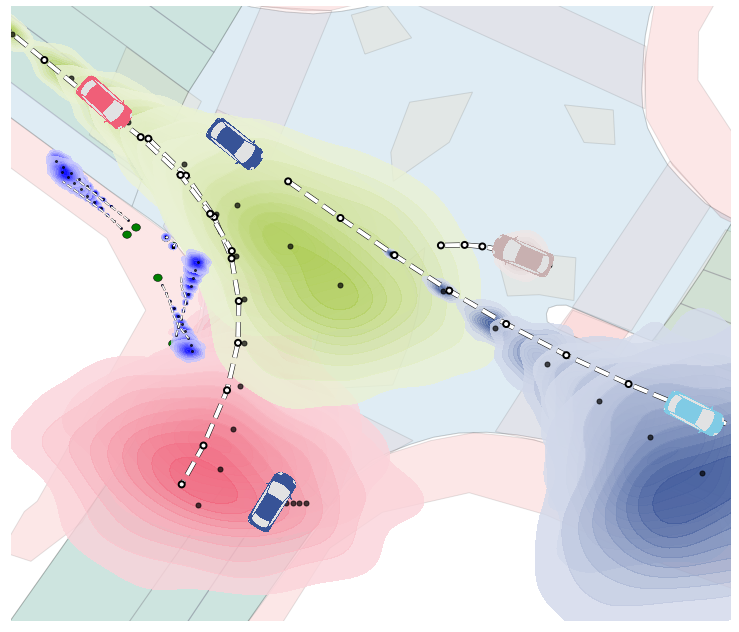

In [15]:
# Prediction with Map Encoding
ph = 10
with torch.no_grad():
    timestep = np.array([2])
    # sample many times and then mock a probability distribution 
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/test.png', dpi=300, bbox_inches='tight')

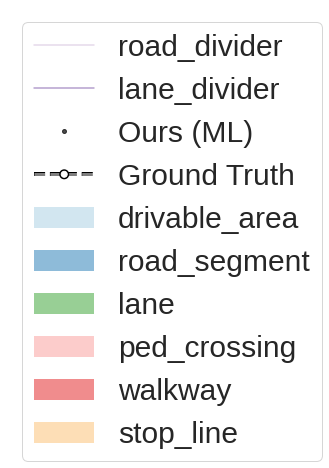

In [16]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')